## Nongaussian data assimilation
Run a nongaussian twin experiment with Lorenz-63, for the MLEF.

In [13]:
# Basic modules
import numpy as np 
import matplotlib.pyplot as plt
from scipy import stats
import pickle
import time

# Lorenz-63 and DA methods
import sys
sys.path.append("../Models/")
sys.path.append("../DataAssimilation/")
import mod_coupledLorenz as L63
import LorenzModels as LM
import mod_MLEF as mlef
import mod_DA_general as da

### Options for data assimilation run

In [14]:
# Options for DA run
period_obs = 100                         # Observation period, in number of time steps
obs_vars = 'xyz'                         # Observed variables, either 'xy', or 'xyz'
var_obs = 1.0                           # Variance of the observations
n_e = 30                                 # Number of ensemble members (only for MLEF)
ml_method = 'array'                     # Nongaussian decision function, either  
                                        #   'array',    selection based on observations before DA run
                                        #   'function', selection from decision function every DA window
sqrtPa_case = 'lagged'
ml_file = './data/kNN_cl63_n10.pkl'      # Location of the trained ML model
seed = None                               # Seed for random number generator, can be set to None
n_wind = 100
SV_init_0 = np.array([-5.0,-6.0,22.0])  # Initial values of the Lorenz-63 run

### Nature run and generating observations

We use the coupled Lorenz-63 model for the twin experiment, which has the following coupled differential equations, for $j \in \{ 1, \ldots, n\}$:
\begin{align*}
\frac{\partial x_j}{\partial t} =& - \sigma (x_j - y_j)     + c_x x_{j+1} \\
\frac{\partial y_j}{\partial t} =& \rho x_j - y_j - z_j x_j + c_y y_{j+1} \\
\frac{\partial z_j}{\partial t} =& x_j y_j - \beta z_j      + c_z z_{j+1}
\end{align*}
with $x_{n+1} = x_{1}$, $y_{n+1} = y_{1}$, and $z_{n+1} = z_{1}$.

To generate the observations, we make use of the machine-learning model, to decide which distribution to sample the $z$-variable from. Before running this example, the machine learning model should be trained by running `train_ML_cL63.py`. 

In [15]:
# Load the machine learning model
with open(ml_file,'rb') as f:
    clf = pickle.load(f)
    scaler = pickle.load(f)
    info = pickle.load(f)
    p = info['p']               # Parameters of L63, typically (10,28,8/3)
    c = info['c']               # Coupling parameters of L63
    n = info['n']               # Number of coupled L63 systems
    dt = info['dt']             # Time step of L63
    integrationMethod = info['integrationMethod']
    t_max = n_wind*period_obs*dt                            # End time of the Lorenz-63 run

# Model function, of the form x = model(t,x_0)
# def model_l63(t, x0):
#     _, y = L63.sol_l63_n([t[0],t[-1]], x0, p, c, n, t, meth='RK45')
#     return y
def model_l63(t, x0):
    y = LM.sol_cL63(t, x0, p, c, n)
    return y

rng = np.random.default_rng(seed)
SV_init_start = np.empty(3*n)
z_indices = []
for ii in range(n):
    SV_init_start[3*ii:3*ii+3] = SV_init_0 + rng.normal(loc = 0.0, scale = 3.0, size = (3))
    z_indices.append(3*ii+2)

# n_t_lag = int(np.floor(period_obs/10))
n_t_lag = period_obs
SV_init, init_guess, sqrtP_a, SV_init_lag = mlef.get_init_condition(\
    SV_init_start, n_e, model_l63, 10000, dt, period_obs, sqrtPa_case, \
    n_t_lag = n_t_lag,
    seed = seed, ln_vars=[], rl_vars=[], xi_add = 5.0)

# Nature run
t = np.arange(0.0, t_max, dt)  # Evaluation time
# t, SV = L63.sol_l63_n([0.0, t_max], SV_init, p, c, n, t_eval, integrationMethod)
SV = model_l63(t, SV_init)
xi_SV = np.nanmax(SV[z_indices,:])+5.0      # Parameter of the reverse lognormal distribution
xi_rand = np.nanmax(SV,axis=1)+5.0      # Parameter of the reverse lognormal distribution
sigma_a = np.std(SV,axis=1)

In [16]:
# Create observation operator
n_SV = 3*n
if obs_vars == 'xyz':
    def obs_h(x):
        return np.copy(x)
    n_obs = 3*n
if obs_vars == 'xy':
    def obs_h(x):
        return np.delete(x,range(2,n_SV,3), axis = 0)
    n_obs = 2*n

# Decision function for lognormal state variables (for a single prediction)
def f_ln_vars(SV):
    ln_vars = []
    for ii in range(n):
        X_data = scaler.transform(SV[0+3*ii:2+3*ii].reshape(1,-1))
        z_pred = clf.predict(X_data)
        if z_pred > 0.5:
            ln_vars.append(2+3*ii)
    return ln_vars
# Decision function for reverse-lognormal state variables (for a single prediction)
def f_rl_vars(SV):
    rl_vars = []
    for ii in range(n):
        X_data = scaler.transform(SV[0+3*ii:2+3*ii].reshape(1,-1))
        z_pred = clf.predict(X_data)
        if z_pred < -0.5:
            rl_vars.append(2+3*ii)
    return rl_vars

# Predict distribution from which to sample z-variable
if obs_vars == 'xyz':
    ln_vars_ML = []
    rl_vars_ML = []
    for ii in range(t.size):
        if ii % period_obs == 0:
            ln_vars_ML.append(f_ln_vars(SV[:,ii]))
            rl_vars_ML.append(f_rl_vars(SV[:,ii]))
if obs_vars == 'xy':
    # If z is not observed, ML model not necessary
    ln_vars_ML = []
    rl_vars_ML = []

# Generate observations
t_obs, y, R = da.gen_obs(t, SV, period_obs, obs_h, var_obs, \
    ln_vars = ln_vars_ML, rl_vars = rl_vars_ML, xi_obs = xi_SV, seed = seed)


### Data assimilation

In [17]:
# Create decision functions/arrays
if ml_method == 'array':
    # Decision function for lognormal observations
    if obs_vars == 'xyz':
        f_ln_vars_obs = f_ln_vars
        f_rl_vars_obs = f_rl_vars
    elif obs_vars == 'xy':
        def f_ln_vars_obs(y):
            ln_vars = []
            for ii in range(n):
                X_data = scaler.transform(y[0+2*ii:2+2*ii].reshape(1,-1))
                z_pred = clf.predict(X_data)
                if z_pred > 0.5:
                    ln_vars.append(2+3*ii)
            return ln_vars
        # Decision function for reverse-lognormal observations
        def f_rl_vars_obs(y):
            rl_vars = []
            for ii in range(n):
                X_data = scaler.transform(y[0+2*ii:2+2*ii].reshape(1,-1))
                z_pred = clf.predict(X_data)
                if z_pred < -0.5:
                    rl_vars.append(2+3*ii)
            return rl_vars
    ln_vars = []
    rl_vars = []
    for ii in range(t_obs.size):
        ln_vars.append(f_ln_vars_obs(y[:,ii]))
        rl_vars.append(f_rl_vars_obs(y[:,ii]))
    ln_Pa0 = ln_vars[0]
    rl_Pa0 = rl_vars[0]
if ml_method == 'function':
    ln_vars = f_ln_vars
    rl_vars = f_rl_vars
    ln_Pa0 = f_ln_vars(init_guess)
    rl_Pa0 = f_rl_vars(init_guess)

# Store different decision functions for different (non)gaussian methods
n_meths = 5
meths = [ \
    'Gaussian ', \
    # 'Lognormal', \
    # 'Rev logn ', \
    'Alternate', \
    'Split    ', \
    'MachLearn', \
    'noDA     ' \
]

ln_vars_SV_OBJ = np.array([ \
    [],                     # Gaussian for all t
    # z_indices,              # Lognormal for all t
    # [],                     # Reverse Lognormal for all t
    z_indices[::2],         # Alternate
    z_indices[:int(n/2)],   # Split
    ln_vars,                # Gaussian - Lognormal - Reverse Lognormal ML
    [],                     # No DA (background run)
], dtype = object)
rl_vars_SV_OBJ = np.array([ \
    [],                     # Gaussian for all t
    # [],                     # Lognormal for all t
    # z_indices,              # Reverse Lognormal for all t
    z_indices[1::2],        # Alternate
    z_indices[int(n/2):],   # Split
    rl_vars,                # Gaussian - Lognormal - Reverse Lognormal ML
    [],                     # No DA (background run)
], dtype = object)
if obs_vars == 'xyz':
    ln_vars_obs_OBJ = ln_vars_SV_OBJ
    rl_vars_obs_OBJ = rl_vars_SV_OBJ
elif obs_vars == 'xy':
    ln_vars_obs_OBJ = np.array([[],[],[],[],[],[],[-1.0]], dtype = object)
    rl_vars_obs_OBJ = np.array([[],[],[],[],[],[],[-1.0]], dtype = object)

ln_vars_Pa_OBJ = np.copy(ln_vars_SV_OBJ)
ln_vars_Pa_OBJ[-2] = ln_Pa0
rl_vars_Pa_OBJ = np.copy(rl_vars_SV_OBJ)
rl_vars_Pa_OBJ[-2] = ln_Pa0

# Initialize analysis and background state variables
n_t_obs = t_obs.size           # number of observations
n_t = n_t_obs * period_obs + 1 # number of total time steps
X_A = np.empty((n_meths, n_SV, n_t_obs))
X_B = np.empty((n_meths, n_SV, n_t))

for iM in range(0,n_meths-1):
    t1 = time.time()
    
    sqrtP_a = mlef.create_sqrtPa_init(sqrtPa_case, n_e, \
            SV_init = SV_init_lag, model = model_l63, n_t = n_t_lag, dt = dt, \
            n_SV = n_SV, sigma_a = sigma_a, \
            seed = seed, ln_vars=ln_vars_Pa_OBJ[iM], rl_vars=rl_vars_Pa_OBJ[iM], xi_add=5.0, xi_rand=xi_rand)
        
    X_A[iM,:,:], X_B[iM,:,:], _ = mlef.MLEF( \
        init_guess, t_obs, period_obs, n_e, y, obs_h, sqrtP_a, R, \
        model_l63, \
        ln_vars_SV = ln_vars_SV_OBJ[iM], ln_vars_obs = ln_vars_obs_OBJ[iM], \
        rl_vars_SV = rl_vars_SV_OBJ[iM], rl_vars_obs = rl_vars_obs_OBJ[iM], \
        xi_SV = xi_SV, xi_obs = xi_SV \
    )
    
    t2 = time.time()
    print("Finished "+meths[iM]+" run, t = "+str(t2-t1))
    
# Background run
iM += 1
dt_obs = t_obs[1] - t_obs[0] # Assuming evenly spaced observations
t_true = np.linspace(t_obs[0],t_obs[-1] + dt_obs, n_t) # Assuming one prediction window
X_B[iM,:,:] = model_l63(t_true, init_guess+rng.normal(size=(n_SV)))
X_A[iM,:,:] = X_B[iM,:,:-1:period_obs]

Finished Gaussian  run, t = 1.6172683238983154
t = 4.0: Warning: Desired error not necessarily achieved due to precision loss.
t = 51.0: Warning: Desired error not necessarily achieved due to precision loss.
t = 56.0: Warning: Desired error not necessarily achieved due to precision loss.
Finished Alternate run, t = 1.7272601127624512
t = 55.0: Warning: CG iterations didn't converge. The Hessian is not positive definite.
t = 56.0: Warning: CG iterations didn't converge. The Hessian is not positive definite.
t = 57.0: Warning: CG iterations didn't converge. The Hessian is not positive definite.
t = 58.0: Warning: CG iterations didn't converge. The Hessian is not positive definite.
t = 59.0: Warning: CG iterations didn't converge. The Hessian is not positive definite.
t = 60.0: Warning: CG iterations didn't converge. The Hessian is not positive definite.
t = 61.0: Warning: CG iterations didn't converge. The Hessian is not positive definite.
t = 62.0: Warning: CG iterations didn't converge

### Plot results

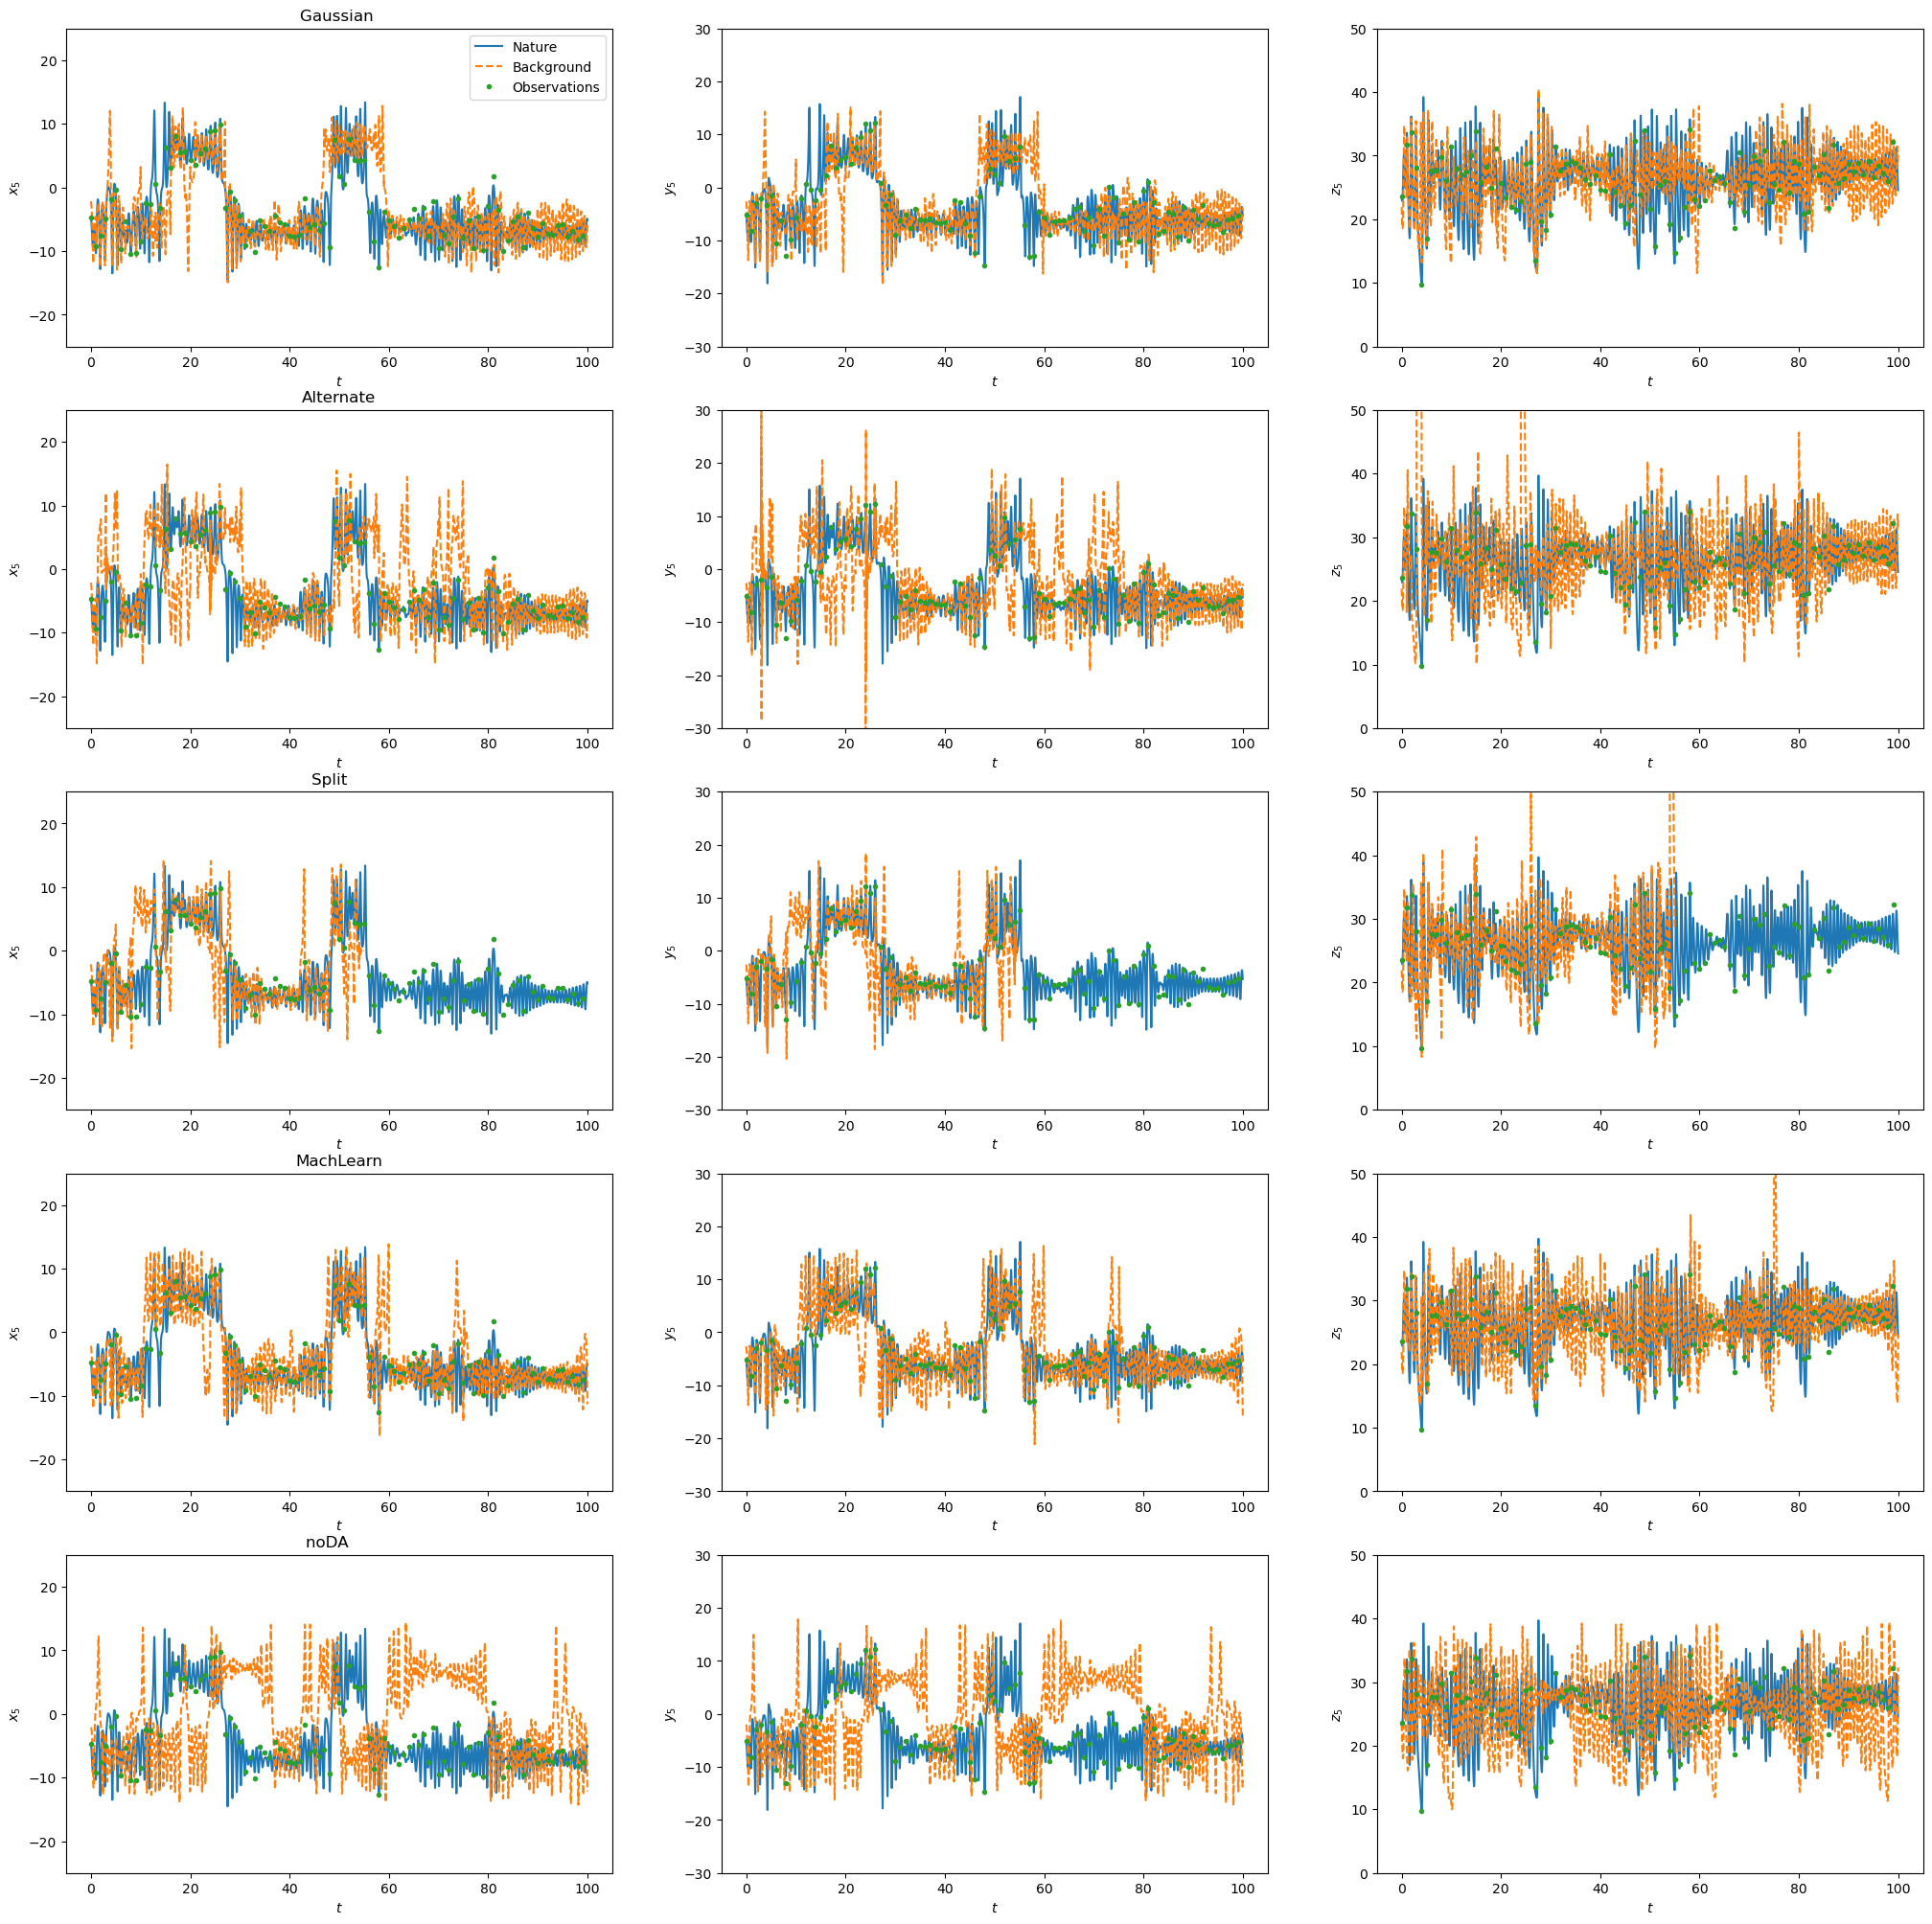

In [18]:
n_plot = 4

fig, ax = plt.subplots(n_meths,3,figsize=(25, 25))
vars = ['$x_'+str(n_plot+1)+'$', '$y_'+str(n_plot+1)+'$', '$z_'+str(n_plot+1)+'$']
for iMeth in range(n_meths):
    for jj in range(3):
        # True state
        ax[iMeth,jj].plot(t,SV[3*n_plot+jj,:],label = 'Nature')
    
        # Background state
        ax[iMeth,jj].plot(t_true,X_B[iMeth,3*n_plot+jj,:],'--',label = 'Background')

        # Observations
        if obs_vars == 'xyz':
            ax[iMeth,jj].plot(t_obs,y[3*n_plot+jj,:],'.',label = 'Observations')
        elif not (jj==2):
            ax[iMeth,jj].plot(t_obs,y[2*n_plot+jj,:],'.',label = 'Observations')

        # # Analysis
        # ax[iMeth,jj].plot(t_obs,X_A[iMeth,3*n_plot+jj,:],'.',label = 'Analysis')

        ax[iMeth,jj].set_xlabel('$t$')
        ax[iMeth,jj].set_ylabel(vars[jj])
    ax[iMeth,0].set_title(meths[iMeth])
    ax[iMeth,0].set_ylim(-25,25)
    ax[iMeth,1].set_ylim(-30,30)
    ax[iMeth,2].set_ylim(0,50)
ax[0,0].legend()

### Performance statistics

In [19]:
RMSE_A = np.empty(n_meths)
RMSE_B = np.empty(n_meths)
print("Root mean square errors")
for iM in range(n_meths):
    RMSE_A[iM] = da.rmse(SV, X_A[iM,:,:], period_DA=period_obs)
    RMSE_B[iM] = da.rmse(SV, X_B[iM,:,:-1])

    print(meths[iM]+ \
        ': r_a = '+format(np.round(RMSE_A[iM],3),".3f")+ \
        ', r_b = '+format(np.round(RMSE_B[iM],3),".3f"))

def mae(SV_true,SV_DA,period_DA = 1):
    # return np.sqrt(np.nanmedian((SV_true[:,::period_DA] - SV_DA)**2))
    # return np.nanmean(np.abs(SV_true[:,::period_DA] - SV_DA))
    return np.nanmean(np.abs(SV_true[:,::period_DA] - SV_DA))

print("")
RmSE_A = np.empty(n_meths)
RmSE_B = np.empty(n_meths)
print("Mean absolute errors")
for iM in range(n_meths):
    RmSE_A[iM] = mae(SV, X_A[iM,:,:], period_DA=period_obs)
    RmSE_B[iM] = mae(SV, X_B[iM,:,:-1])

    print(meths[iM]+ \
        ': r_a = '+format(np.round(RmSE_A[iM],3),".3f")+ \
        ', r_b = '+format(np.round(RmSE_B[iM],3),".3f"))

Root mean square errors
Gaussian : r_a = 4.196, r_b = 5.464
Alternate: r_a = 25.244, r_b = 12.862
Split    : r_a = 40.775, r_b = 16.997
MachLearn: r_a = 5.570, r_b = 5.988
noDA     : r_a = 8.510, r_b = 8.727

Mean absolute errors
Gaussian : r_a = 2.841, r_b = 3.625
Alternate: r_a = 5.846, r_b = 5.691
Split    : r_a = 5.120, r_b = 5.122
MachLearn: r_a = 3.446, r_b = 4.137
noDA     : r_a = 6.811, r_b = 6.968
